<a href="https://colab.research.google.com/github/YuriArduino/Estudos_Artificial_Intelligence/blob/Imers%C3%A3o-Agentes-de-IA---Alura/RAG_Evaluation_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preâmbulo: A Jornada de um Framework de Avaliação de RAG**

O que começou como um exercício da **Aula 2 da Imersão Dev (Agentes de IA) da Alura**, focado em construir um sistema simples de RAG (Retrieval-Augmented Generation), rapidamente se transformou em uma pergunta muito mais profunda e fundamental: **como podemos medir, otimizar e, acima de tudo, confiar nos resultados de um sistema de RAG?**

A resposta a essa pergunta é a jornada documentada neste notebook.

## **Da Incerteza à Engenharia**

A intuição inicial era clara: aceitar os parâmetros padrão de um `splitter` ou `retriever` é trabalhar às cegas. Um sistema de IA que não pode ser medido não é confiável. O primeiro passo foi simples: construir um contador de tokens, um monitor de API. Mas isso apenas arranhou a superfície.

A verdadeira virada aconteceu ao confrontar os desafios do mundo real:

1.  **O Problema da Relevância:** Como saber se os `chunks` que o sistema de busca recupera são realmente úteis? Apenas a similaridade matemática não era suficiente.
2.  **O Problema da Alucinação:** Como garantir que o sistema diga "não sei" em vez de inventar uma resposta quando a informação não existe nos documentos?
3.  **O Problema da Otimização:** Qual combinação de `chunk_size` e `chunk_overlap` é objetivamente a melhor? E como provar isso com dados?

## **A Arquitetura da Solução: Um Laboratório de MLOps**

A resposta exigiu uma refatoração completa, quebrando um script monolítico em um conjunto de **especialistas de software**, cada um com sua responsabilidade única, inspirados nos princípios de design SOLID:

*   Um **`LLMAdapter`** para criar uma camada resiliente sobre a API.
*   Um **`RelevanceEvaluator`** para atuar como nosso "LLM Juiz".
*   Um **`MetricsCalculator`** para computar métricas padrão da indústria (Precision, Recall, F1-Score).
*   E a peça central: um **`GroundTruthGenerator`**.

### **A Inovação: `LLM-derived Ground-Truth`**

Em vez de criar um "gabarito" manual – um processo lento e sujeito a viés –, decidimos usar a própria IA como uma "anotadora de dados". O `GroundTruthGenerator` varre todo o nosso conhecimento e usa o Gemini para criar um gabarito objetivo, que se torna a nossa "verdade fundamental" para todos os testes subsequentes.

## **O Resultado Final: Um Framework Científico**

Este notebook é a documentação dessa jornada. Ele não é apenas uma implementação de RAG, mas um **framework de avaliação** completo, um verdadeiro laboratório de MLOps que permite a qualquer desenvolvedor:

1.  **Carregar** um conjunto de documentos.
2.  **Definir** múltiplas estratégias de RAG para comparar.
3.  **Gerar** um gabarito de alta qualidade de forma automática.
4.  **Executar** uma análise comparativa sistemática.
5.  **Visualizar** os resultados em um dashboard claro e acionável.

## **Capítulo 1: Preparação do Ambiente de Análise**

Esta é a célula fundamental que prepara todo o nosso ambiente de trabalho. Ela é dividida em duas etapas essenciais: a **instalação das ferramentas** e a **importação dos módulos** que usaremos ao longo do notebook.

### **1.1 Instalações Necessárias**

A primeira linha de comando (`!pip install...`) funciona como a montagem da nossa "bancada de trabalho". Ela instala todas as bibliotecas externas que o nosso projeto precisa para funcionar. O `-q` (`quiet`) apenas torna a saída menos verbosa.

**O "Porquê" de cada ferramenta:**

*   **Análise e Visualização:**
    *   `pandas`, `matplotlib`, `seaborn`: A tríade clássica da ciência de dados em Python. Usaremos para estruturar e plotar nossos resultados finais em tabelas e gráficos.
*   **Componentes do Pipeline RAG (LangChain):**
    *   `langchain_community`, `langchain_google_genai`: O coração da nossa conexão com os modelos do Google.
    *   `faiss-cpu`: A nossa "memória vetorial". É o banco de dados da Meta AI que armazena os embeddings dos nossos documentos de forma eficiente, rodando na CPU (não exige GPU).
    *   `pymupdf`: Um leitor de PDFs de alta performance, que o LangChain usa para extrair o texto dos nossos arquivos de políticas.
*   **Utilitários:**
    *   `requests`: O "carteiro" da internet. Usado para baixar os arquivos PDF a partir das URLs do GitHub.

### **1.2 Imports**

Após instalar as ferramentas, esta seção as "liga" e as torna disponíveis para uso no nosso notebook. Organizamos os imports em grupos lógicos para maior clareza.

*   **Módulos Padrão do Python:**
    *   Ferramentas essenciais para manipulação de sistema (`os`), dados (`json`), tempo (`time`), texto (`re`), arquivos (`tempfile`), estatísticas (`statistics`), erros (`traceback`) e datas (`datetime`).
    *   `dataclasses`, `typing`, `abc`: Módulos que nos ajudam a escrever um código mais moderno, estruturado e seguro, definindo "contratos" claros para nossas classes e funções.

*   **Módulos de Análise de Dados:**
    *   `pandas as pd`, `matplotlib.pyplot as plt`, `seaborn as sns`: Importamos a tríade com seus apelidos convencionais (`pd`, `plt`, `sns`), uma prática padrão na comunidade.

*   **Módulos Específicos do LangChain:**
    *   Aqui importamos as "peças de LEGO" específicas que vamos montar: o **Modelo de Linguagem** (`ChatGoogleGenerativeAI`), o **Modelo de Embedding** (`GoogleGenerativeAIEmbeddings`), o **Carregador de Documentos** (`PyMuPDFLoader`), o **Divisor de Texto** (`RecursiveCharacterTextSplitter`) e a **Base de Vetores** (`FAISS`).

> **Nota para o Futuro:** Se algum dia o notebook quebrar com um erro de `ModuleNotFoundError`, é muito provável que a solução esteja em adicionar a biblioteca faltante na lista de instalações da seção 1.1.

---

In [1]:
# 1.1 Instalações necessárias
!pip install -q pandas matplotlib seaborn langchain_community langchain_google_genai faiss-cpu pymupdf requests


# 1.2 Imports
# Built-in
import os
import json
import time
import re
import tempfile
import statistics
import traceback
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, Tuple, Protocol
from datetime import datetime
from urllib.parse import unquote
from abc import ABC, abstractmethod
from pathlib import Path
import pickle
import hashlib
import logging
from typing import List, Optional

from pydantic import BaseModel



# Third-party
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS


## **Capítulo 2: Definindo as Estruturas de Dados (Data Models)**

Antes de escrevermos a lógica complexa do nosso analisador, definimos claramente as **estruturas de dados** que ele irá manipular.  
Separar a definição dos dados da lógica (o código que os processa) é uma prática de engenharia de software chamada **Separação de Preocupações** (`Separation of Concerns`), que torna nosso código mais organizado, seguro e fácil de entender.

Desta vez, em vez de usarmos `@dataclass` do Python puro, adotamos **Pydantic v2 (`BaseModel`)**.  
Isso nos traz **superpoderes adicionais**:

* **Validação automática de tipos**: se tentarmos atribuir um `str` em um campo que deveria ser `float`, o Pydantic gera um erro imediatamente.
* **Serialização prática**: podemos salvar e carregar resultados facilmente usando `.model_dump()` e `.model_validate_json()`.
* **Imutabilidade opcional**: podemos "congelar" os objetos para que não sejam alterados acidentalmente depois de criados.

---

### **Os Nossos Modelos de Dados (versão Pydantic v2):**

1. **`ChunkAnalysisResult`**  
   - **Propósito:** Representa o resultado da análise de **um único chunk** recuperado pelo sistema de busca.  
   - Campos: conteúdo, score de similaridade, julgamento de relevância, confiança do LLM, raciocínio textual e tempo de execução.

2. **`AnalysisMetrics`**  
   - **Propósito:** Consolida todas as **métricas de performance quantitativas** de um experimento.  
   - Campos: precisão, recall, f1-score, precisão em diferentes `k`, verdadeiros positivos, contagem de recuperados e de ground truth.

3. **`ChunkingStrategy`**  
   - **Propósito:** Define formalmente uma "receita" de chunking, com seu nome, tamanho e sobreposição.  
   - Campos: `name`, `chunk_size` e `chunk_overlap`.

4. **`RetrievalExperiment`**  
   - **Propósito:** É o nosso **objeto principal de resultados**.  
   - Campos: estratégia usada, query, `k` testado, chunks recuperados, resultados individuais, métricas consolidadas, tempo de execução e recomendações adicionais.

> **Nota para o Futuro:** Ao usar Pydantic v2, qualquer tentativa de instanciar esses objetos com tipos errados gerará um erro de validação imediato. Isso previne muitos bugs silenciosos durante o desenvolvimento.

---

In [2]:
class ChunkAnalysisResult(BaseModel):
    """Resultado da análise de um chunk individual."""
    id: int
    content: str
    score: float
    is_relevant: bool
    confidence_score: Optional[float] = None
    reasoning: Optional[str] = None
    evaluation_time: Optional[float] = None


class AnalysisMetrics(BaseModel):
    """Métricas de performance de um experimento."""
    precision: float
    recall: float
    f1_score: float
    precision_at_k: dict[int, float]
    true_positives: int
    retrieved_count: int
    ground_truth_count: int


class ChunkingStrategy(BaseModel):
    """Estratégia de chunking."""
    name: str
    chunk_size: int
    chunk_overlap: int


class RetrievalExperiment(BaseModel):
    """Resultado completo de um experimento de retrieval."""
    strategy: ChunkingStrategy
    query: str
    k_tested: int
    total_chunks: int
    results: List[ChunkAnalysisResult]
    metrics: AnalysisMetrics
    execution_time: float
    recommended_k: Optional[int] = None
    recommended_threshold: Optional[float] = None
    cost_estimate: Optional[float] = None

    class Config:
        frozen = True  # torna o objeto imutável (value object)


## **Capítulo 3: Definindo os Contratos de Comportamento (Protocolos)**

Nesta célula, definimos as **interfaces** ou **contratos** para os componentes externos do nosso sistema, como o modelo de linguagem (LLM) e o banco de dados de vetores (Vector Store).

Em vez de acoplar nosso analisador diretamente a uma classe específica (como `ChatGoogleGenerativeAI` ou `FAISS`), nós usamos `Protocol` do Python.  
Um protocolo define **o que um objeto deve ser capaz de fazer**, sem se importar com **como ele faz**.  
É como definir o que significa ser um "veículo" (ter rodas, acelerar, frear) sem se prender a uma "Ferrari" ou um "Fusca".

Essa abordagem, conhecida como **Inversão de Dependência**, torna nosso código extremamente flexível e fácil de testar.

---

### **Os Nossos Contratos:**

1. **`LLMClient`**
   - **Contrato:** Qualquer objeto que queira atuar como um cliente de LLM em nosso sistema **deve** ter um método chamado `invoke` que aceita uma `string` (o prompt) e retorna um dicionário com os resultados.
   - **Benefício:** Se amanhã quisermos trocar o Gemini pelo OpenAI, ou por um modelo local via Ollama, não precisamos mudar nada no nosso `AdvancedRAGAnalyzer`. Basta criar um novo "adaptador" que implemente este protocolo.

2. **`VectorStore`**
   - **Contrato:** Qualquer objeto que queira atuar como um banco de dados de vetores **deve** ter um método `similarity_search_with_score` que busca por uma `query` e retorna uma lista de documentos e seus scores.
   - **Benefício:** Se no futuro decidirmos que o `FAISS` não é mais a melhor opção e quisermos migrar para `ChromaDB`, `Pinecone` ou outro serviço, nosso analisador continuará funcionando perfeitamente, desde que o novo banco de dados respeite este contrato.

> **Nota para o Futuro:** O uso de Protocolos é o que permite a **injeção de dependência**.  
> Em vez de o nosso analisador *criar* suas próprias dependências (o LLM, o Vector Store), ele as recebe prontas em seu construtor (`__init__`).  
> Isso facilita imensamente os testes, pois podemos "injetar" versões falsas (mocks) do LLM e do Vector Store para testar a lógica do analisador de forma isolada, sem fazer chamadas de API reais.

---

In [3]:
from typing import Protocol, Any


class LLMClient(Protocol):
    """Protocolo para clientes LLM."""
    def invoke(self, prompt: str) -> dict[str, Any]:
        """Invoca o LLM com um prompt e retorna resposta normalizada."""
        ...


class VectorStore(Protocol):
    """Protocolo para vector stores."""
    def similarity_search_with_score(self, query: str, k: int) -> list[tuple[Any, float]]:
        """Busca por similaridade retornando documentos e scores."""
        ...

## **Capítulo 4: Implementando o Sistema de Cache Persistente**

"""
A etapa de geração de "ground truth" e a avaliação de cada chunk são os gargalos de performance
e custo do nosso pipeline. Executar dezenas ou centenas de chamadas de API a cada vez que rodamos
o notebook é inviável.

A classe `ExperimentCache` resolve esse problema com um sistema de **cache persistente** que:
1. Gera chaves únicas baseadas em parâmetros + conteúdo dos documentos.
2. Usa `pickle` para salvar e restaurar experimentos completos.
3. Faz logging estruturado para depuração profissional.

Assim, rodamos uma análise pesada uma vez e depois reutilizamos os resultados em segundos.


In [4]:
import hashlib
import pickle
import logging
from pathlib import Path
from typing import List, Optional, Any

# Configuração básica de logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

class ExperimentCache:
    """
    Sistema de cache persistente para experimentos de RAG.
    Salva e carrega resultados de ground truth e de experimentos completos.
    """

    def __init__(self, cache_dir: str = ".rag_cache"):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.info(f"Cache inicializado no diretório: {self.cache_dir.resolve()}")

    # --- MÉTODOS DE HASHING E CHAVE (INTERNOS) ---
    def _hash_docs_content(self, documents: List[Any]) -> str:
        """Gera um hash do conteúdo dos documentos para detectar mudanças."""
        content_sample = "".join([getattr(doc, "page_content", str(doc))[:200] for doc in documents])
        return hashlib.md5(content_sample.encode()).hexdigest()

    def _get_gt_cache_key(self, strategy: "ChunkingStrategy", query: str, docs_hash: str) -> str:
        """Gera uma chave de cache para o ground truth."""
        key_data = f"gt_{strategy.chunk_size}_{strategy.chunk_overlap}_{query}_{docs_hash}"
        return hashlib.md5(key_data.encode()).hexdigest()

    def _get_exp_cache_key(self, strategy: "ChunkingStrategy", query: str, docs_hash: str) -> str:
        """Gera uma chave de cache para um experimento completo."""
        key_data = f"exp_{strategy.name}_{query}_{docs_hash}"
        return hashlib.md5(key_data.encode()).hexdigest()

    # --- MÉTODOS PARA GROUND TRUTH ---
    def get_ground_truth(self, strategy: "ChunkingStrategy", query: str, documents: List[Any]) -> Optional[set]:
        docs_hash = self._hash_docs_content(documents)
        cache_key = self._get_gt_cache_key(strategy, query, docs_hash)
        cache_file = self.cache_dir / f"{cache_key}.pkl"

        if cache_file.exists():
            try:
                with open(cache_file, "rb") as f:
                    ground_truth_set = pickle.load(f)
                self.logger.info(f"Cache HIT para Ground Truth (query: '{query[:30]}...')")
                return ground_truth_set
            except Exception as e:
                self.logger.warning(f"Falha ao carregar cache de GT '{cache_file}': {e}. Removendo.")
                cache_file.unlink(missing_ok=True)

        self.logger.info(f"Cache MISS para Ground Truth (query: '{query[:30]}...')")
        return None

    def save_ground_truth(self, ground_truth_set: set, strategy: "ChunkingStrategy", query: str, documents: List[Any]):
        docs_hash = self._hash_docs_content(documents)
        cache_key = self._get_gt_cache_key(strategy, query, docs_hash)
        cache_file = self.cache_dir / f"{cache_key}.pkl"

        try:
            temp_file = cache_file.with_suffix(".tmp")
            with open(temp_file, "wb") as f:
                pickle.dump(ground_truth_set, f)
            temp_file.replace(cache_file)  # salvamento atômico
            self.logger.info(f"Ground Truth salvo no cache (query: '{query[:30]}...')")
        except Exception as e:
            self.logger.error(f"Falha ao salvar Ground Truth no cache: {e}")

    # --- MÉTODOS PARA EXPERIMENTOS COMPLETOS ---
    def get_experiment(self, strategy: "ChunkingStrategy", query: str, documents: List[Any]) -> Optional["RetrievalExperiment"]:
        docs_hash = self._hash_docs_content(documents)
        cache_key = self._get_exp_cache_key(strategy, query, docs_hash)
        cache_file = self.cache_dir / f"{cache_key}.pkl"

        if cache_file.exists():
            try:
                with open(cache_file, "rb") as f:
                    experiment = pickle.load(f)
                self.logger.info(f"Cache HIT para Experimento '{strategy.name}'")
                return experiment
            except Exception as e:
                self.logger.warning(f"Falha ao carregar cache de Experimento: {e}. Removendo.")
                cache_file.unlink(missing_ok=True)

        self.logger.info(f"Cache MISS para Experimento '{strategy.name}'")
        return None

    def save_experiment(self, experiment: "RetrievalExperiment", query: str, documents: List[Any]):
        docs_hash = self._hash_docs_content(documents)
        cache_key = self._get_exp_cache_key(experiment.strategy, query, docs_hash)
        cache_file = self.cache_dir / f"{cache_key}.pkl"

        try:
            temp_file = cache_file.with_suffix(".tmp")
            with open(temp_file, "wb") as f:
                pickle.dump(experiment, f)
            temp_file.replace(cache_file)  # salvamento atômico
            self.logger.info(f"Experimento '{experiment.strategy.name}' salvo no cache.")
        except Exception as e:
            self.logger.error(f"Falha ao salvar Experimento no cache: {e}")

    def clear_cache(self):
        """Remove todos os arquivos de cache do diretório."""
        for cache_file in self.cache_dir.glob("*.pkl"):
            cache_file.unlink()
        self.logger.info("Cache de experimentos completamente limpo.")


## **Capítulo 5: Implementando o Adaptador de LLM**

"""
A classe `LLMAdapter` atua como uma camada de adaptação entre nosso sistema e qualquer cliente LLM.
Sua única responsabilidade é fornecer uma interface unificada, resiliente e previsível para chamadas
a LLMs, independentemente da biblioteca utilizada.

Ela resolve três problemas principais:
1. Diferentes formas de invocar LLMs (`invoke`, `generate`, função direta).
2. Diferentes formatos de resposta (AIMessage, Generation, dict, string).
3. Fragilidade em chamadas de API (adiciona retry com exponential backoff).


In [5]:
import time
import logging
from typing import Any, Dict

class LLMAdapter:
    """
    Adapter para normalizar diferentes clientes LLM.
    Responsabilidade única: interface unificada para LLMs.
    """

    def __init__(self, llm: Any, max_retries: int = 2, retry_backoff: float = 1.0):
        self.llm = llm
        self.max_retries = max_retries
        self.retry_backoff = retry_backoff
        self.logger = logging.getLogger(self.__class__.__name__)

    def invoke(self, prompt: str) -> Dict[str, Any]:
        """Invoca o LLM com retry automático e resposta normalizada."""
        last_exception = None

        for attempt in range(self.max_retries + 1):
            try:
                response = self._try_invoke(prompt)
                return self._normalize_response(response)
            except Exception as e:
                last_exception = e
                if attempt < self.max_retries:
                    wait_time = self.retry_backoff * (2 ** attempt)
                    self.logger.warning(
                        f"Erro na chamada do LLM (tentativa {attempt+1}/{self.max_retries+1}): {e}. "
                        f"Tentando novamente em {wait_time:.1f}s..."
                    )
                    time.sleep(wait_time)

        # Se todas as tentativas falharem, loga o erro e retorna um fallback padronizado
        self.logger.error(f"Falha definitiva ao invocar LLM após {self.max_retries+1} tentativas: {last_exception}")
        return {"content": f"__LLM_ERROR__: {str(last_exception)}"}

    def _try_invoke(self, prompt: str) -> Any:
        """Tenta invocar o LLM usando diferentes interfaces comuns."""
        if hasattr(self.llm, "invoke"):
            return self.llm.invoke(prompt)
        if hasattr(self.llm, "generate"):
            return self.llm.generate([prompt])
        if callable(self.llm):  # fallback genérico
            return self.llm(prompt)
        raise TypeError("O objeto LLM fornecido não é chamável nem possui os métodos 'invoke' ou 'generate'.")

    def _normalize_response(self, response: Any) -> Dict[str, Any]:
        """Normaliza diferentes formatos de resposta para um formato padrão e seguro."""
        try:
            if isinstance(response, dict) and "content" in response:
                return response
            if hasattr(response, "generations"):  # LangChain style
                try:
                    gen = response.generations[0][0]
                    text = getattr(gen, "text", str(gen))
                    return {"content": text}
                except Exception:
                    return {"content": "__LLM_EMPTY_GENERATION__"}
            if hasattr(response, "content"):  # AIMessage
                return {"content": response.content}
            if hasattr(response, "text"):
                return {"content": response.text}
            if isinstance(response, str):
                return {"content": response}
            return {"content": str(response)}  # fallback genérico
        except Exception as e:
            self.logger.error(f"Erro ao normalizar resposta LLM: {e} -- raw: {response}")
            return {"content": f"__LLM_NORMALIZE_ERROR__: {e} -- raw: {str(response)}"}


## **Capítulo 6: Implementando o "LLM Juiz" (Relevance Evaluator)**

Esta classe, `RelevanceEvaluator`, é o nosso "LLM Juiz" encapsulado.  
Ela é a segunda implementação de um componente focado no **Princípio da Responsabilidade Única**.  

Sua única missão é: **receber uma pergunta e uma lista de trechos (`chunks`) e determinar, com a ajuda de um LLM, se cada trecho é relevante para responder à pergunta.**

Ao isolar essa lógica em sua própria classe, nosso sistema principal (`AdvancedRAGAnalyzer`) se torna mais limpo e independente dos detalhes de como a relevância é julgada.

---

### **Responsabilidades da Classe**

1. **Construção de Prompts (`_build_batch_prompt`):**
   - **Função:** Cria o prompt exato que será enviado ao LLM.  
     O formato exige resposta **em JSON válido e estrito**, o que aumenta a confiabilidade.  
   - **Benefício:** Centraliza a engenharia de prompt em um só método.

2. **Parsing Robusto da Resposta (`_parse_json_from_response`):**
   - **Função:** Extrai e valida o JSON retornado pelo LLM, tolerando pequenas variações na saída.  
   - **Benefício:** Torna a aplicação resiliente a erros de API e outputs inesperados.

3. **Orquestração da Avaliação (`evaluate_batch`):**
   - **Função:** Coordena o fluxo: divide os trechos em lotes, constrói prompts, chama o LLM e interpreta as respostas.  
   - **Benefício:** Mantém a classe testável e previsível.

---

> **Nota de Design:**  
> A classe foi projetada para suportar avaliação em lote (batch), garantindo eficiência no uso da API.  
> Em um cenário real, é recomendável criar **testes unitários específicos para `_parse_json_from_response`**, simulando saídas bem e mal formatadas do LLM, sem precisar consumir a API de verdade.

---

In [6]:
class RelevanceEvaluator:
    """
    Avalia a relevância de chunks usando um LLM de forma eficiente e robusta.

    - Suporta avaliação em lote (batch) para reduzir chamadas de API.
    - Espera que cada chunk possua um 'chunk_id' único e estável.
    - Exige que o LLM responda em JSON válido para maior confiabilidade.
    """
    def __init__(self, llm_adapter: LLMAdapter,
                 confidence_threshold: float = 50.0,
                 batch_size: int = 5):
        self.llm_adapter = llm_adapter
        self.confidence_threshold = float(confidence_threshold)
        self.batch_size = int(batch_size)
        self.SYSTEM_INSTRUCTION = (
            "Você é um avaliador de relevância. RESPONDA APENAS com um JSON válido e nada mais. "
            "Formato esperado: {\"results\":[{\"id\":\"<chunk_id>\",\"is_relevant\":\"SIM\"|\"NAO\",\"confidence\":0-100}]}"
        )

    def evaluate_batch(self, query: str, items: List[Tuple[str, str]]) -> Dict[str, Tuple[bool, float]]:
        """
        Avalia uma lista de trechos (chunks) em lotes.

        Args:
            query (str): Pergunta que guia a avaliação.
            items (List[Tuple[str, str]]): Lista de tuplas (chunk_id, snippet).

        Returns:
            Dict[str, Tuple[bool, float]]:
                Mapeamento chunk_id -> (is_relevant, confidence).
        """
        results: Dict[str, Tuple[bool, float]] = {}
        for i in range(0, len(items), self.batch_size):
            sub_batch = items[i:i + self.batch_size]
            prompt = self._build_batch_prompt(query, sub_batch)

            raw_content = self.llm_adapter.invoke(prompt).get("content", "")
            parsed_batch = self._parse_json_from_response(raw_content)

            if parsed_batch is None:
                # Retry com instrução ainda mais explícita se o parsing falhar
                raw_content_retry = self.llm_adapter.invoke("RESPOSTA APENAS COM JSON: " + prompt).get("content", "")
                parsed_batch = self._parse_json_from_response(raw_content_retry)

            parsed_map = {res.get("id"): res for res in parsed_batch.get("results", [])} if parsed_batch else {}

            for chunk_id, _ in sub_batch:
                item = parsed_map.get(chunk_id)
                if not item:
                    # Fallback se o LLM não retornar um item esperado
                    results[chunk_id] = (False, 0.0)
                    continue

                is_relevant_text = str(item.get("is_relevant", "")).upper()
                confidence = float(item.get("confidence", 0.0))

                is_relevant = ("SIM" in is_relevant_text) and (confidence >= self.confidence_threshold)
                results[chunk_id] = (is_relevant, confidence)
        return results

    def _build_batch_prompt(self, query: str, items: List[Tuple[str, str]]) -> str:
        """Constrói o prompt para avaliação de vários trechos de uma vez."""
        prompt_snippets = ""
        for chunk_id, snippet in items:
            # json.dumps garante que o texto seja serializado de forma segura
            sanitized_snippet = json.dumps(snippet[:1200])
            prompt_snippets += f"[ID:{chunk_id}]\n{sanitized_snippet}\n\n"

        return (
            f"{self.SYSTEM_INSTRUCTION}\n"
            f"PERGUNTA: \"{query}\"\n\n"
            f"TRECHOS PARA AVALIAR:\n{prompt_snippets}"
            "RETORNE apenas o JSON pedido."
        )

    def _parse_json_from_response(self, raw_text: str) -> Optional[Dict[str, Any]]:
        """
        Extrai e valida o primeiro JSON encontrado em um texto.

        Args:
            raw_text (str): Saída textual do LLM.

        Returns:
            Optional[Dict[str, Any]]: Estrutura JSON extraída, ou None em caso de falha.
        """
        if not raw_text:
            return None
        match = re.search(r'\{.*\}', raw_text, re.DOTALL)
        if not match:
            return None
        try:
            return json.loads(match.group(0))
        except json.JSONDecodeError:
            return None  # Retorna None se o JSON estiver malformado


## **Capítulo 7: Implementando a Calculadora de Métricas**

A classe `MetricsCalculator` é o nosso especialista em matemática.  
Ela encapsula toda a lógica para calcular as métricas de performance que definimos em nossos modelos de dados.

Seguindo o **Princípio da Responsabilidade Única**, sua única função é:  
**receber os resultados de um experimento e um "gabarito" (`ground_truth_set`) e transformá-los em números que nos dizem quão bem o sistema se comportou.**

Ao isolar esses cálculos, o nosso orquestrador (`AdvancedRAGAnalyzer`) se torna mais limpo e focado em sua tarefa principal: **gerenciar o fluxo do experimento.**

---

### **Responsabilidades da Classe**

1. **Cálculo de Métricas Principais (`calculate_metrics`):**
   - **Função:** Método principal que calcula a tríade sagrada:
     - **Precision (Precisão):** Dos documentos recuperados, quantos eram corretos?
     - **Recall (Revocação):** De todos os documentos corretos, quantos foram recuperados?
     - **F1-Score:** A média harmônica entre Precision e Recall, que resume o equilíbrio do sistema.
   - **Benefício:** Fornece uma visão holística da qualidade do sistema.

2. **Cálculo de Precision@K (`_calculate_precision_at_k`):**
   - **Função:** Mede a precisão considerando apenas os **k** primeiros resultados.  
   - **Benefício:** Essencial para avaliar a "primeira página" de resultados, já que usuários raramente olham além dela.

3. **Otimização de Threshold (`find_optimal_threshold`):**
   - **Função:** Itera sobre os scores de similaridade e encontra o `threshold` que maximiza o F1-Score.  
   - **Benefício:** Fornece uma recomendação quantitativa para ajustar o parâmetro `score_threshold` do sistema.

---

> **Nota de Design:**  
> Todos os métodos são `@staticmethod`, ou seja, **não dependem de estado interno**.  
> Isso os torna **funções puras**, fáceis de testar isoladamente e reutilizar em outros projetos.

---

In [7]:
class MetricsCalculator:
    @staticmethod
    def calculate_metrics(results: List[ChunkAnalysisResult],
                         ground_truth_ids: set,
                         k_values: List[int] = None) -> AnalysisMetrics:
        """
        Calcula métricas globais (precision, recall, f1-score) e precision@k.

        Args:
            results (List[ChunkAnalysisResult]): Lista de resultados avaliados.
            ground_truth_ids (set): Conjunto de IDs considerados corretos.
            k_values (List[int], opcional): Valores de K para calcular precision@k.
                                            Default: [1, 3, 5, 8, 10].

        Returns:
            AnalysisMetrics: Objeto com todas as métricas calculadas.
        """
        if k_values is None:
            k_values = [1, 3, 5, 8, 10]

        retrieved_ids = {r.id for r in results}
        true_positives_ids = retrieved_ids.intersection(ground_truth_ids)

        total_retrieved = len(retrieved_ids)
        total_relevant_in_corpus = len(ground_truth_ids)
        total_true_positives = len(true_positives_ids)

        precision = total_true_positives / total_retrieved if total_retrieved > 0 else 0
        recall = total_true_positives / total_relevant_in_corpus if total_relevant_in_corpus > 0 else 0
        f1_score = (
            2 * (precision * recall) / (precision + recall)
            if (precision + recall) > 0 else 0
        )

        precision_at_k = MetricsCalculator._calculate_precision_at_k(results, ground_truth_ids, k_values)

        return AnalysisMetrics(
            precision=precision,
            recall=recall,
            f1_score=f1_score,
            precision_at_k=precision_at_k,
            true_positives=total_true_positives,
            retrieved_count=total_retrieved,
            ground_truth_count=total_relevant_in_corpus
        )

    @staticmethod
    def _calculate_precision_at_k(results: List[ChunkAnalysisResult],
                                 ground_truth_ids: set,
                                 k_values: List[int]) -> Dict[int, float]:
        """
        Calcula a precisão nos primeiros K resultados (precision@k).

        Args:
            results (List[ChunkAnalysisResult]): Resultados avaliados.
            ground_truth_ids (set): IDs corretos no gabarito.
            k_values (List[int]): Lista de valores de K a considerar.

        Returns:
            Dict[int, float]: Mapeamento de K -> valor da precisão@k.
        """
        precision_at_k = {}
        sorted_results = sorted(results, key=lambda x: x.score, reverse=True)  # maior score = mais relevante

        for k in k_values:
            if k <= len(sorted_results):
                top_k_ids = {r.id for r in sorted_results[:k]}
                true_positives_at_k = len(top_k_ids.intersection(ground_truth_ids))
                precision_at_k[k] = true_positives_at_k / k if k > 0 else 0

        return precision_at_k

    @staticmethod
    def find_optimal_threshold(results: List[ChunkAnalysisResult]) -> float:
        """
        Encontra o threshold ótimo baseado no F1-score,
        usando o julgamento do "LLM Juiz" (`is_relevant`).

        Args:
            results (List[ChunkAnalysisResult]): Lista de resultados avaliados.

        Returns:
            float: Threshold ótimo que maximiza o F1-score.
        """
        if not results:
            return 0.0

        sorted_results = sorted(results, key=lambda x: x.score, reverse=True)
        best_threshold = sorted_results[0].score
        best_f1 = 0.0
        total_relevant_in_results = sum(1 for r in sorted_results if r.is_relevant)

        if total_relevant_in_results == 0:
            return best_threshold

        for result in sorted_results:
            threshold = result.score
            filtered = [x for x in sorted_results if x.score >= threshold]

            relevant_retrieved = sum(1 for x in filtered if x.is_relevant)
            total_retrieved = len(filtered)

            precision = relevant_retrieved / total_retrieved if total_retrieved else 0
            recall = relevant_retrieved / total_relevant_in_results if total_relevant_in_results else 0
            f1 = (
                2 * (precision * recall) / (precision + recall)
                if (precision + recall) > 0 else 0
            )

            if f1 >= best_f1:
                best_f1 = f1
                best_threshold = threshold

        return float(best_threshold)


## **Capítulo 8: Implementando o "Anotador de Dados" (Ground Truth Generator)**

Esta classe, `GroundTruthGenerator`, é o componente que automatiza a tarefa mais crítica e trabalhosa em qualquer projeto de avaliação de Machine Learning: a criação de um **"ground truth"** ou "gabarito".

Sua **responsabilidade única** é iterar sobre um conjunto completo de documentos (`chunks`) e, para uma pergunta específica, usar a inteligência de um LLM para criar uma lista definitiva de quais chunks contêm a resposta. Este processo é conhecido como **`LLM-derived ground-truth`**.

### **Responsabilidades da Classe:**

1.  **Orquestração da Análise (`derive_ground_truth`):**
    *   **Função:** O método principal que gerencia o processo. Ele percorre cada chunk do nosso corpus, um por um, e chama o LLM para julgá-lo.
    *   **Importância:** Este é um processo que consome muitos recursos (tempo e chamadas de API), pois analisa **todo** o nosso conhecimento, não apenas os resultados de uma busca. Ele é executado apenas uma vez no início do nosso experimento para criar o gabarito.

2.  **Avaliação Individual (`_is_chunk_relevant`):**
    *   **Função:** Constrói um prompt simples e direto (SIM/NÃO) e usa o `LLMAdapter` para obter o veredito do LLM sobre um único chunk.
    *   **Design:** A lógica está isolada neste método, tornando-o fácil de modificar no futuro se quisermos usar um prompt de avaliação diferente.

> **Nota para o Futuro:** A criação de um `ground_truth` é o que nos permite calcular métricas objetivas como **Recall** e **F1-Score**. Sem um gabarito, só poderíamos medir a Precision (a qualidade do que foi recuperado), mas nunca saberíamos o que ficou de fora (Recall). Esta classe, embora simples, é o que eleva nosso framework de uma simples ferramenta de diagnóstico para uma suíte de avaliação de performance completa.

In [8]:
import re
import json
import time
from typing import List, Dict, Set
from pydantic import BaseModel, Field, ValidationError
from langchain.schema import Document


class GroundTruthResult(BaseModel):
    """Modelo validado para cada item do ground truth."""
    id: str = Field(..., description="Identificador único do chunk avaliado")
    is_relevant: str = Field(..., pattern="^(SIM|NAO)$", description="Relevância do chunk")


class GroundTruthGenerator:
    """
    Classe responsável por derivar o 'ground truth' usando um LLM.
    Ela avalia todos os chunks disponíveis e determina, via prompt estruturado,
    quais realmente contêm informação suficiente para responder a uma query.
    """

    def __init__(self, llm_adapter: "LLMAdapter"):
        self.llm_adapter = llm_adapter

    def _parse_batch_response(self, raw_text: str) -> Dict[str, GroundTruthResult]:
        """Extrai e parseia um JSON da resposta do LLM de forma robusta."""
        match = re.search(r'\{.*\}', raw_text, re.DOTALL)
        if not match:
            # Heurística fallback: detecta "SIM" solto no texto
            if re.search(r'\bSIM\b', raw_text, re.IGNORECASE):
                first_id_match = re.search(r'\[ID:(.+?)\]', raw_text)
                if first_id_match:
                    return {
                        first_id_match.group(1): GroundTruthResult(
                            id=first_id_match.group(1),
                            is_relevant="SIM"
                        )
                    }
            return {}

        try:
            parsed_json = json.loads(match.group(0))
            results_list = parsed_json.get("results", [])

            validated_results = {}
            for item in results_list:
                try:
                    result = GroundTruthResult(**item)
                    validated_results[result.id] = result
                except ValidationError:
                    continue  # ignora itens inválidos
            return validated_results

        except (json.JSONDecodeError, TypeError):
            return {}

    def derive_ground_truth(
        self,
        chunks: List[Document],
        query: str,
        batch_size: int = 5,
        pause_between: float = 6.0
    ) -> Set[str]:
        """
        Deriva o conjunto de IDs de chunks relevantes para a query fornecida.
        Analisa TODOS os chunks, em lotes, usando o LLM.
        """
        print(f"\n🤖 Derivando Ground Truth com LLM (lotes de {batch_size}) para: '{query}'")
        print(f"📚 Total de chunks a analisar: {len(chunks)}")

        relevant_chunk_ids: Set[str] = set()

        system_prompt = (
            "Você é um avaliador de relevância. Analise a lista de trechos e, para cada um, "
            "determine se ele contém informação suficiente para responder à pergunta. "
            "RESPONDA APENAS COM UM ÚNICO BLOCO JSON VÁLIDO contendo um array 'results'."
        )

        for i in range(0, len(chunks), batch_size):
            batch_chunks = chunks[i:i + batch_size]

            prompt_snippets = ""
            for chunk in batch_chunks:
                chunk_id = chunk.metadata.get("chunk_id", f"chunk_{i}")
                snippet = chunk.page_content.replace("\n", " ").replace('"', "'")[:700]
                prompt_snippets += f"[ID:{chunk_id}]\n{snippet}\n\n"

            prompt = (
                f"{system_prompt}\n\n"
                f"PERGUNTA: \"{query}\"\n\n"
                f"TRECHOS PARA AVALIAR:\n{prompt_snippets}"
                "FORMATO DE RESPOSTA (JSON):\n"
                "{\"results\":[{\"id\":\"ID_DO_TRECHO_1\",\"is_relevant\":\"SIM\"|\"NAO\"},"
                " {\"id\":\"ID_DO_TRECHO_2\",\"is_relevant\":\"SIM\"|\"NAO\"}]}"
            )

            response_text = self.llm_adapter.invoke(prompt).get("content", "")
            parsed_results = self._parse_batch_response(response_text)

            # Atualiza o ground truth
            for chunk in batch_chunks:
                chunk_id = chunk.metadata.get("chunk_id")
                result_for_chunk = parsed_results.get(chunk_id)
                is_relevant = result_for_chunk and result_for_chunk.is_relevant == "SIM"

                if is_relevant:
                    relevant_chunk_ids.add(chunk_id)

                print(f"  - Chunk ID {chunk_id}: {'✅ Relevante' if is_relevant else '❌ Irrelevante'}")

            if i + batch_size < len(chunks):
                time.sleep(pause_between)

        print(f"\n✅ Ground Truth concluído! Total relevantes: {len(relevant_chunk_ids)}")
        return relevant_chunk_ids

## **Capítulo 9: O Orquestrador Principal (RAG Analyzer)**

Finalmente, chegamos ao cérebro da nossa operação: a classe `RAGAnalyzer`.

Após termos criado nossos componentes especialistas (`LLMAdapter`, `RelevanceEvaluator`, `MetricsCalculator`, `GroundTruthGenerator`), cada um com sua responsabilidade única, o `RAGAnalyzer` atua como o **maestro da orquestra**. Sua única função é **coordenar** esses especialistas para executar o fluxo de trabalho completo de uma análise de RAG.

Este design, baseado no princípio de **Composição**, resulta em um código limpo, desacoplado e que espelha uma arquitetura de software de produção.

### **Responsabilidades da Classe:**

1.  **Composição dos Especialistas (`__init__`):**
    *   **Função:** No momento de sua criação, o `RAGAnalyzer` constrói as instâncias de todos os seus "assistentes" especialistas. Ele recebe o `llm_adapter` como dependência externa, praticando a **Injeção de Dependência**.

2.  **Orquestração da Análise (`analyze_strategy`):**
    *   **Função:** Este é o método principal. Ele executa a sequência lógica de uma análise:
        1.  Delega a busca de documentos para o `VectorStore`.
        2.  Delega a avaliação de cada documento recuperado para o `RelevanceEvaluator`.
        3.  Delega o cálculo das métricas finais para o `MetricsCalculator`.
        4.  Monta e armazena o resultado final em um objeto `RetrievalExperiment`.

3.  **Apresentação dos Resultados (`_display_results`):**
    *   **Função:** Formata e imprime um resumo claro e informativo dos resultados de um experimento, tornando a saída fácil de interpretar.

4.  **Interface de Conveniência (`generate_ground_truth`):**
    *   **Função:** Fornece um atalho simples para que o usuário final possa, através do `RAGAnalyzer`, acessar a funcionalidade do `GroundTruthGenerator` sem precisar interagir com ele diretamente.

> **Nota para o Futuro:** A beleza desta arquitetura é a sua extensibilidade. Se quisermos adicionar um novo passo ao nosso pipeline (por exemplo, um "Re-ranker" que reordena os resultados antes da avaliação), precisaríamos apenas criar uma nova classe especialista (`ReRanker`) e adicionar uma nova chamada de delegação no método `analyze_strategy`. O resto do sistema permaneceria inalterado.

In [9]:
class RAGAnalyzer:
    def __init__(self, llm_adapter: LLMAdapter):
        self.llm_adapter = llm_adapter
        self.relevance_evaluator = RelevanceEvaluator(llm_adapter)
        self.metrics_calculator = MetricsCalculator()
        self.ground_truth_generator = GroundTruthGenerator(llm_adapter)
        self.experiments_history: List[RetrievalExperiment] = []

    def analyze_strategy(self, vectorstore: VectorStore, strategy: ChunkingStrategy,
                         query: str, ground_truth_set: set, total_chunks: int,
                         k_values: List[int] = None, pause_between_evals: float = 0) -> Optional[RetrievalExperiment]:
        if k_values is None: k_values = [1, 3, 5, 8, 10]
        max_k = max(k_values)
        start_time = time.time()
        print(f"\n🔍 Analisando estratégia: {strategy.name} (k={max_k})")

        try:
            docs_with_scores = vectorstore.similarity_search_with_score(query, k=max_k)
        except Exception as e:
            print(f"❌ Erro na recuperação de documentos: {e}")
            return None
        if not docs_with_scores:
            print("  - Nenhum documento encontrado na busca.")
            return None

        # O LLM Juiz ainda avalia os chunks recuperados para análise qualitativa
        results = self._evaluate_retrieved_chunks(docs_with_scores, query, pause_between_evals)

        # <<< A MUDANÇA IMPORTANTE ESTÁ AQUI >>>
        # O cálculo de métricas agora recebe a lista de chunks recuperados, que contêm
        # o chunk_id original e estável.
        metrics = self.metrics_calculator.calculate_metrics(results, ground_truth_set, k_values)

        execution_time = time.time() - start_time
        experiment = RetrievalExperiment(
            strategy=strategy, query=query, k_tested=max_k,
            total_chunks=total_chunks, results=results, metrics=metrics,
            execution_time=execution_time,
            recommended_threshold=self.metrics_calculator.find_optimal_threshold(results)
        )
        self._display_results(experiment)
        self.experiments_history.append(experiment)
        return experiment

    def _evaluate_retrieved_chunks(self, docs_with_scores: List[Tuple[Any, float]],
                                 query: str, pause_between: float) -> List[ChunkAnalysisResult]:
        results = []
        print(f"  - Avaliando {len(docs_with_scores)} chunks recuperados com o 'LLM Juiz'...")

        items_to_evaluate = []
        for doc, score in docs_with_scores:
            # O chunk_id já deve existir no metadata do documento recuperado
            chunk_id = doc.metadata.get('chunk_id', 'id_nao_encontrado')
            items_to_evaluate.append((chunk_id, doc.page_content))

        # A avaliação em lote retorna um dicionário {chunk_id: (is_relevant, confidence)}
        batch_results = self.relevance_evaluator.evaluate_batch(query, items_to_evaluate)

        for i, (doc, score) in enumerate(docs_with_scores):
            chunk_id = doc.metadata.get('chunk_id', f'id_nao_encontrado_{i}')
            is_relevant, confidence = batch_results.get(chunk_id, (False, 0.0))

            results.append(ChunkAnalysisResult(
                id=chunk_id, # <<< USA O ID ESTÁVEL E ORIGINAL >>>
                content=doc.page_content,
                score=float(score),
                is_relevant=is_relevant,
                confidence_score=confidence,
                reasoning="Avaliado em lote",
                evaluation_time=None
            ))
            print(f"    - Chunk ID {chunk_id}: {'✅ Relevante' if is_relevant else '❌ Irrelevante'} (Confiança: {confidence:.0f}%)")

        return results


    def _display_results(self, experiment: RetrievalExperiment):
        """Exibe os resultados formatados de um experimento."""
        metrics = experiment.metrics

        print("\n" + "-"*60)
        print("📊 RESULTADOS DA ANÁLISE")
        print("-" * 60)
        print(f"Estratégia: {experiment.strategy.name} ({experiment.strategy.chunk_size}/{experiment.strategy.chunk_overlap})")
        print(f"Ground Truth: {metrics.ground_truth_count} chunks relevantes")
        print(f"Recuperados: {metrics.retrieved_count} | Acertos: {metrics.true_positives}")
        print("-" * 30)
        print(f"🎯 Precision: {metrics.precision:.2%}")
        print(f"🎣 Recall: {metrics.recall:.2%}")
        print(f"⚖️ F1-Score: {metrics.f1_score:.2%}")
        print("\n📈 Precision@K:")
        for k, v in sorted(metrics.precision_at_k.items()):
            print(f"  P@{k}: {v:.2%}")
        if experiment.recommended_threshold is not None:
            print(f"🎚️ Threshold Recomendado: {experiment.recommended_threshold:.4f}")
        print(f"⏱️ Tempo Total da Análise: {experiment.execution_time:.2f}s")
        print("-" * 60)

    def generate_ground_truth(self, chunks: List[Any], query: str, pause_between: float = 0) -> set:
        """Método de conveniência para acessar o gerador de ground truth."""
        return self.ground_truth_generator.derive_ground_truth(chunks, query, pause_between)

## **Capítulo 10: Implementando o Utilitário de Carregamento de Documentos**

Com todos os nossos componentes de análise e lógica definidos, a última peça da nossa arquitetura de software é um utilitário limpo para a **entrada de dados**.

A classe `DocumentLoader` segue o **Princípio da Responsabilidade Única** ao encapsular toda a complexidade de baixar e extrair texto de arquivos PDF a partir de URLs.

### **Responsabilidades da Classe:**

1.  **Orquestração do Carregamento (`load_from_urls`):**
    *   **Função:** Itera sobre uma lista de URLs e gerencia o processo de carregamento de cada um.
    *   **Resiliência:** Se o download de um arquivo falhar, ele imprime um erro e continua para o próximo, em vez de quebrar todo o processo.

2.  **Lógica de Download e Parsing (`_load_single_url`):**
    *   **Função:** Contém a lógica de baixo nível para um único arquivo.
    *   **Inteligência de URL:** Inclui uma lógica específica para detectar URLs do GitHub e convertê-los para o formato de download "raw" (`/raw/`), garantindo que estamos baixando o arquivo PDF real, e não a página HTML de visualização.
    *   **Gerenciamento de Arquivos:** Usa a biblioteca `tempfile` do Python para criar um arquivo temporário de forma segura, garantindo que ele seja automaticamente limpo após o uso, mesmo em caso de erro.

> **Nota para o Futuro:** O design desta classe torna muito fácil estendê-la para suportar novos formatos no futuro. Poderíamos adicionar métodos como `_load_single_docx_url` ou `_load_single_html_url` e o método principal `load_from_urls` saberia como chamá-los com base na extensão do arquivo, sem que o resto do nosso notebook precise mudar.

In [10]:
class DocumentLoader:
    """
    Utilitário para carregar documentos de fontes externas como URLs.
    Responsabilidade: Abstrair a lógica de download, parsing e CORREÇÃO
    DE METADADOS dos arquivos remotos.
    """

    @staticmethod
    def load_from_urls(urls: List[str], timeout: int = 20) -> List[Any]:
        """
        Carrega documentos de uma lista de URLs, lidando com erros individuais.
        """
        print("\n--- Etapa 2: Carregando Documentos ---")
        loaded_docs = []

        for url in urls:
            try:
                # O método _load_single_url agora retorna os docs com metadados corrigidos
                docs = DocumentLoader._load_single_url(url, timeout)
                loaded_docs.extend(docs)
                print(f"  ✅ Carregado: {unquote(url)} ({len(docs)} páginas)")
            except Exception as e:
                print(f"  ❌ Erro ao carregar {unquote(url)}: {e}")

        print(f"✅ {len(loaded_docs)} documentos carregados no total.")
        return loaded_docs

    @staticmethod
    def _load_single_url(url: str, timeout: int) -> List[Any]:
        """
        Carrega um documento PDF de uma única URL, corrigindo os metadados 'source'.
        """
        download_url = url
        if "github.com" in url and "/blob/" in url and "?raw=true" not in url:
            download_url = url.replace("/blob/", "/raw/", 1)

        response = requests.get(download_url, timeout=timeout)
        response.raise_for_status()

        with tempfile.NamedTemporaryFile(suffix=".pdf") as tmp_file:
            tmp_file.write(response.content)
            tmp_file.flush()

            loader = PyMuPDFLoader(tmp_file.name)
            docs_carregados = loader.load()

            # Decodifica o nome do arquivo original
            nome_arquivo_original = unquote(url.split('/')[-1])
            # Itera sobre cada página carregada e corrige seus metadados
            for doc in docs_carregados:
                # Substitui a 'source' temporária pela 'source' permanente
                doc.metadata['source'] = nome_arquivo_original

            return docs_carregados

## **Capítulo 11: O Orquestrador de Experimentos (Comparative Analyzer)**

Chegamos à camada mais alta da nossa arquitetura de software: o `ComparativeAnalyzer`. Se o `RAGAnalyzer` é o "motor de análise" que avalia uma configuração, o `ComparativeAnalyzer` é o "engenheiro de testes" que executa uma bateria de experimentos.

Sua **responsabilidade única** é gerenciar e comparar múltiplos `RetrievalExperiment`, permitindo-nos testar diferentes hipóteses (neste caso, estratégias de chunking) de forma sistemática para encontrar a configuração ótima.

### **Responsabilidades da Classe:**

1.  **Orquestração de Alto Nível (`run_analysis`):**
    *   **Função:** O método principal que recebe uma lista de `ChunkingStrategy` e, para cada uma, executa o ciclo completo de análise:
        1.  Cria os `chunks` e o `VectorStore` específicos para a estratégia.
        2.  Delega a análise dessa configuração para o `RAGAnalyzer`.
        3.  Coleta e compila as métricas de performance de cada experimento.
    *   **Benefício:** Abstrai toda a complexidade de um teste A/B/C, tornando o processo de comparação de estratégias uma única chamada de função.

2.  **Gerenciamento do Ciclo de Vida do Experimento:**
    *   **Função:** Inclui a lógica para pausar entre os experimentos, garantindo que não sobrecarreguemos a API do LLM com muitas chamadas em um curto período.

3.  **Compilação dos Resultados:**
    *   **Função:** Ao final de todos os testes, ele consolida os resultados chave em um `pandas DataFrame`, o formato ideal para a visualização e análise de dados que faremos a seguir.

> **Nota para o Futuro:** O design desta classe é o pináculo da modularidade. Ela depende apenas das **interfaces** (Protocolos) e das **estruturas de dados** (Dataclasses) que definimos. Isso significa que poderíamos reutilizar o `ComparativeAnalyzer` para testar outras variáveis do nosso sistema, como diferentes **modelos de embedding** ou diferentes **tipos de retriever**, com modificações mínimas, simplesmente criando novas listas de "estratégias" para testar.

In [11]:
class ComparativeAnalyzer:
    def __init__(self, rag_analyzer: RAGAnalyzer, cache: Optional[ExperimentCache] = None):
        self.rag_analyzer = rag_analyzer
        self.cache = cache

    def run_analysis(self, docs, embeddings_model, strategies, query, ground_truth_set, pause_between=15):
        analysis_results = []
        for i, strategy in enumerate(strategies):
            print(f"\n{'='*90}\n🧪 Testando Estratégia {i+1}/{len(strategies)}: {strategy.name} ({strategy.chunk_size}/{strategy.chunk_overlap})")

            experiment = self.cache.get_experiment(strategy, query, docs) if self.cache else None

            if not experiment:
                vectorstore, total_chunks = self._create_vectorstore(docs, strategy, embeddings_model)
                if vectorstore:
                    experiment = self.rag_analyzer.analyze_strategy(
                        vectorstore, strategy, query, ground_truth_set, total_chunks,
                        pause_between_evals=6
                    )
                    if experiment and self.cache:
                        self.cache.save_experiment(experiment, query, docs)

            if experiment:
                # ... (seu código para compilar os 'strategy_results' aqui) ...
                strategy_results = {
                    'Estratégia': strategy.name, 'Query': query,
                    'Precision (%)': experiment.metrics.precision * 100,
                    'Recall (%)': experiment.metrics.recall * 100,
                    'F1-Score (%)': experiment.metrics.f1_score * 100,
                    'Acertos': experiment.metrics.true_positives,
                    'Recuperados': experiment.metrics.retrieved_count,
                    'Gabarito': experiment.metrics.ground_truth_count
                }
                analysis_results.append(strategy_results)

            if i < len(strategies) - 1:
                print(f"⏳ Pausando {pause_between}s...")
                time.sleep(pause_between)

        return pd.DataFrame(analysis_results)

    def _create_vectorstore(self, docs: List[Any], strategy: ChunkingStrategy, embeddings_model: Any) -> Tuple[Optional[VectorStore], int]:
        """
        Método auxiliar para criar o vectorstore para uma estratégia específica.
        """
        print("  - Criando chunks e gerando embeddings...")
        try:
            splitter = RecursiveCharacterTextSplitter(
                chunk_size=strategy.chunk_size,
                chunk_overlap=strategy.chunk_overlap
            )
            chunks = splitter.split_documents(docs)
            print(f"    → {len(chunks)} chunks gerados.")

            # A chamada à API de embeddings (custosa) acontece aqui
            vectorstore = FAISS.from_documents(chunks, embeddings_model)
            return vectorstore, len(chunks)

        except Exception as e:
            print(f"    ❌ Erro ao criar VectorStore: {e}")
            return None, 0

## **Capítulo 12: A Célula de Visualização (O Dashboard de Resultados)**

Esta é a célula final do nosso pipeline de implementação. Sua única responsabilidade é pegar os dados numéricos compilados pelo `ComparativeAnalyzer` e traduzi-los em **visualizações claras e intuitivas**.

Um bom gráfico é, muitas vezes, a forma mais eficaz de comunicar os resultados de uma análise complexa. Em vez de uma única visualização, criamos um **dashboard 2x2**, onde cada gráfico responde a uma pergunta específica sobre a performance das nossas estratégias.

### **Análise do Dashboard:**

1.  **Gráfico 1 (Superior Esquerdo): Comparativo de Métricas Principais**
    *   **O que é:** Um gráfico de barras agrupado.
    *   **Pergunta que responde:** "Como as estratégias se comparam nas três métricas fundamentais (Precision, Recall, F1-Score) lado a lado?"
    *   **Como ler:** Ele nos dá a visão mais completa da performance. Uma estratégia ideal teria barras altas em todas as três métricas.

2.  **Gráfico 2 (Superior Direito): Contagem de Acertos**
    *   **O que é:** Um gráfico de barras simples.
    *   **Pergunta que responde:** "Em termos absolutos, qual estratégia foi mais eficaz em *encontrar* a informação relevante?"
    *   **Como ler:** Esta é a nossa medida de eficácia bruta. Uma barra mais alta significa que a estratégia conseguiu recuperar mais "pedaços" corretos do nosso gabarito.

3.  **Gráfico 3 (Inferior Esquerdo): O Trade-off: Precision vs. Recall**
    *   **O que é:** Um gráfico de dispersão (scatter plot).
    *   **Pergunta que responde:** "Existe um trade-off entre ser preciso e encontrar tudo? Qual estratégia oferece o melhor equilíbrio?"
    *   **Como ler:** O "canto superior direito" deste gráfico é o ponto ideal (alta precisão e alto recall). O **tamanho e a cor da bolha** representam o F1-Score, nos mostrando visualmente qual estratégia encontrou o melhor equilíbrio.

4.  **Gráfico 4 (Inferior Direito): Ranking Final por F1-Score**
    *   **O que é:** Um gráfico de barras horizontal e ordenado.
    *   **Pergunta que responde:** "Qual é a conclusão final? Qual estratégia é a vencedora?"
    *   **Como ler:** Este é o nosso "pódio". As estratégias são ranqueadas pela métrica de equilíbrio (F1-Score), da pior para a melhor. As cores e as linhas de referência nos dão uma classificação instantânea de performance (vermelho/laranja/verde).

> **Nota para o Futuro:** Este dashboard é a ponte entre nossa análise técnica e a tomada de decisão. É a parte do projeto que você mostraria para um líder de equipe, um gerente de produto ou um cliente para justificar suas escolhas de arquitetura de forma clara, visual e baseada em dados.

In [12]:
def plot_evaluation_heatmap(results_df: pd.DataFrame):
    """
    Plota um heatmap mostrando a performance (F1-Score) de cada estratégia
    em cada uma das perguntas de teste.
    """
    if results_df.empty:
        print("❌ Nenhum resultado para plotar.")
        return

    # Prepara a matriz para o heatmap
    heatmap_data = results_df.pivot(index='Estratégia', columns='Query', values='F1-Score (%)')

    plt.figure(figsize=(16, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", linewidths=.5, cmap="viridis",
                cbar_kws={'label': 'F1-Score (%)'})

    plt.title('Heatmap de Performance de Estratégias de RAG (F1-Score %)', fontsize=18, weight='bold')
    plt.xlabel('Perguntas de Teste', fontsize=12)
    plt.ylabel('Estratégias de Chunking', fontsize=12)
    plt.xticks(rotation=15, ha="right")
    plt.yticks(rotation=0)
    plt.show()

def print_final_analysis_aggregated(results_df: pd.DataFrame):
    """
    Imprime uma análise final agregada, calculando a média de performance
    e declarando a estratégia vencedora.
    """
    print("\n" + "="*80)
    print("🏆 ANÁLISE FINAL AGREGADA DOS RESULTADOS")
    print("="*80)

    # Calcula a performance média de cada estratégia
    summary = results_df.groupby('Estratégia').agg(
        Avg_F1_Score=('F1-Score (%)', 'mean'),
        Avg_Precision=('Precision (%)', 'mean'),
        Avg_Recall=('Recall (%)', 'mean')
    ).reset_index().sort_values(by='Avg_F1_Score', ascending=False)

    print("📊 TABELA DE PERFORMANCE MÉDIA:")
    print("="*80)
    print(summary.to_string(index=False, float_format='%.2f'))
    print("="*80)

    # Declara o vencedor
    if not summary.empty:
        winner = summary.iloc[0]
        print(f"\n🥇 ESTRATÉGIA VENCEDORA (Maior Média de F1-Score): '{winner['Estratégia']}'")
        print(f"   - ⚖️ Média de F1-Score: {winner['Avg_F1_Score']:.2f}%")
        print(f"   - 🎯 Média de Precision: {winner['Avg_Precision']:.2f}%")
        print(f"   - 🎣 Média de Recall: {winner['Avg_Recall']:.2f}%")

    print("\n💡 RECOMENDAÇÃO:")
    print("A estratégia vencedora demonstrou o melhor equilíbrio de performance em todo o conjunto de testes.")
    print("O heatmap acima mostra visualmente a consistência de cada estratégia. Estratégias com cores consistentemente 'quentes' (amarelo/verde) são as mais robustas.")
    print("="*80)

## **Capítulo 13: O Utilitário de Carregamento de Documentos**

Esta é a última classe de "especialista" da nossa arquitetura. A classe `DocumentLoader` encapsula toda a lógica de **entrada de dados**, baixando e extraindo o texto de arquivos PDF a partir de URLs.

Ao isolar esta funcionalidade, nosso script de execução principal se torna muito mais limpo, focando apenas em orquestrar a análise, sem se preocupar com os detalhes de como os documentos são obtidos.

In [13]:
def carregar_documentos_de_urls(lista_de_urls: list, timeout: int = 20) -> list:
    """
    Baixa e carrega PDFs, sobrescrevendo os metadados 'source' com o nome
    do arquivo original para a criação de IDs estáveis.
    """
    print("\n--- Carregando Documentos ---")
    documentos_finais = []

    for url in lista_de_urls:
        # Decodifica o nome do arquivo para usar como 'source' estável
        nome_arquivo = unquote(url.split('/')[-1])

        try:
            with tempfile.NamedTemporaryFile(suffix=".pdf") as tmp:
                dl_url = url + "?raw=true" if "github.com" in url and "?raw=true" not in url else url
                resp = requests.get(dl_url, timeout=timeout)
                resp.raise_for_status()
                tmp.write(resp.content)
                tmp.flush()

                loader = PyMuPDFLoader(tmp.name)
                docs_carregados = loader.load()

                # <<< A CORREÇÃO CRÍTICA ESTÁ AQUI >>>
                # Itera sobre cada página carregada e corrige seus metadados
                for doc in docs_carregados:
                    doc.metadata['source'] = nome_arquivo

                documentos_finais.extend(docs_carregados)
            print(f"  ✅ '{nome_arquivo}' carregado ({len(docs_carregados)} páginas).")

        except Exception as e:
            print(f"  ❌ Erro ao carregar '{nome_arquivo}': {e}")

    print(f"Carregamento concluído: {len(documentos_finais)} páginas totais carregadas.")
    return documentos_finais

In [14]:
# NOVA CÉLULA: GERADOR DE ID DE CHUNK ESTÁVEL

def adicionar_ids_estaveis_aos_chunks(chunks: List[Any]):
    """
    Itera sobre uma lista de chunks e adiciona um 'chunk_id' único e
    determinístico em seus metadados.
    """
    for i, chunk in enumerate(chunks):
        source = Path(chunk.metadata.get('source', 'doc_desconhecido')).name
        page = chunk.metadata.get('page', 'N/A')

        # O ID é uma combinação do nome do arquivo, página e índice do chunk
        chunk_id = f"{source}::p{page}::c{i}"
        chunk.metadata['chunk_id'] = chunk_id

## **Capítulo 14: A Função Principal `main()`**

Com todos os nossos componentes e classes especialistas definidos, esta célula contém a função `main()`, que atua como o **orquestrador mestre** de todo o nosso pipeline.

Ela define a sequência lógica de operações, do início ao fim:
1.  Configura os modelos de LLM e Embedding.
2.  Usa o `DocumentLoader` para carregar os dados.
3.  Define as `ChunkingStrategy` que queremos comparar.
4.  Usa o `GroundTruthGenerator` para criar nosso gabarito.
5.  Usa o `ComparativeAnalyzer` para executar os experimentos.
6.  Chama as funções de visualização e análise para apresentar os resultados.

Manter a lógica de execução principal dentro de uma função `main()` é uma prática padrão que torna o código organizado e fácil de entender.


In [15]:
def main():
    """
    Função principal que executa a avaliação completa, testando
    múltiplas estratégias contra um conjunto de perguntas críticas.
    """
    print("="*80)
    print(" INICIANDO FRAMEWORK DE AVALIAÇÃO DE RAG")
    print("="*80)

    # --- Etapa 0: Inicializar o Cache ---
    experiment_cache = ExperimentCache()

    # --- Etapa 1: Configuração dos Modelos ---
    print("\n--- Etapa 1: Configurando Modelos ---")
    try:
        from google.colab import userdata
        os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY_3')
        llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
        embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
        llm_adapter = LLMAdapter(llm)
        print("✅ Modelos configurados com sucesso!")
    except Exception as e:
        print(f"❌ Erro na configuração: {e}.")
        return

    # --- Etapa 2: Carregamento dos Documentos ---
    urls = [
        "https://github.com/YuriArduino/Estudos_Artificial_Intelligence/blob/Dados/Pol%C3%ADtica%20de%20Reembolsos%20(Viagens%20e%20Despesas).pdf",
        "https://github.com/YuriArduino/Estudos_Artificial_Intelligence/blob/Dados/Pol%C3%ADtica%20de%20Uso%20de%20E-mail%20e%20Seguran%C3%A7a%20da%20Informa%C3%A7%C3%A3o.pdf",
        "https://github.com/YuriArduino/Estudos_Artificial_Intelligence/blob/Dados/Pol%C3%ADticas%20de%20Home%20Office.pdf"
    ]
    docs = DocumentLoader.load_from_urls(urls)
    if not docs: return

    # --- Etapa 3: Definição do Conjunto de Avaliação ---
    print("\n--- Etapa 3: Definindo o Conjunto de Avaliação ---")
    strategies = [
        ChunkingStrategy("Pequeno (150/50)", 150, 50),
        ChunkingStrategy("Médio (500/100)", 500, 100),
        ChunkingStrategy("Grande (1000/200)", 1000, 200)
    ]
    evaluation_queries = [
        "Posso reembolsar a internet do meu home office?",
        "Quero mais 5 dias de trabalho remoto. Como faço?",
        "Posso reembolsar cursos ou treinamentos da Alura?",
        "Quantas capivaras tem no Rio Pinheiros?"
    ]
    print(f"✅ {len(strategies)} estratégias e {len(evaluation_queries)} perguntas de teste definidas.")

    # --- Etapa 4: Gerando o Corpus de Ground Truth ---
    print("\n--- Etapa 4: Gerando o Corpus de Ground Truth ---")
    ground_truth_generator = GroundTruthGenerator(llm_adapter)

    # Usamos a estratégia mais granular para criar o gabarito mais preciso
    gt_strategy = ChunkingStrategy("GT (150/50)", 150, 50) # Damos um nome à estratégia de GT
    splitter_gt = RecursiveCharacterTextSplitter(chunk_size=gt_strategy.chunk_size, chunk_overlap=gt_strategy.chunk_overlap)
    chunks_for_gt = splitter_gt.split_documents(docs)

    # Adicionamos os IDs aos chunks ANTES de qualquer outra operação.
    adicionar_ids_estaveis_aos_chunks(chunks_for_gt)

    # Criamos um dicionário de gabaritos, um para cada pergunta
    ground_truth_corpus = {}
    for query in evaluation_queries:
        # Tenta carregar do cache primeiro
        cached_gt = experiment_cache.get_ground_truth(gt_strategy, query, docs)

        if cached_gt is not None:
            ground_truth_corpus[query] = cached_gt
        else:
            # Se não estiver no cache, gera e depois salva
            gt_set = ground_truth_generator.derive_ground_truth(
                chunks_for_gt, query, batch_size=5, pause_between=6
            )
            ground_truth_corpus[query] = gt_set
            experiment_cache.save_ground_truth(gt_set, gt_strategy, query, docs)

    # --- Etapa 5: Executando Análise Comparativa com Cache ---
    print("\n--- Etapa 5: Executando Análise Comparativa com Cache ---")
    rag_analyzer = RAGAnalyzer(llm_adapter)
    comparative_analyzer = ComparativeAnalyzer(rag_analyzer, cache=experiment_cache)

    all_results_list = []
    for query in evaluation_queries:
        df_for_query = comparative_analyzer.run_analysis(
            docs=docs, embeddings_model=embeddings, strategies=strategies,
            query=query, ground_truth_set=ground_truth_corpus.get(query, set()),
            pause_between=15
        )
        all_results_list.append(df_for_query)

    results_df = pd.concat(all_results_list, ignore_index=True)

    # --- Etapa 6: Visualização e Análise Final ---
    print("\n--- Etapa 6: Exibindo Resultados Finais Agregados ---")
    if not results_df.empty:
        plot_evaluation_heatmap(results_df) # Nova função de plotagem
        print_final_analysis_aggregated(results_df) # Nova função de análise
        export_results_to_csv(results_df)
    else:
        print("❌ Nenhum resultado foi gerado na análise comparativa.")

## **Capítulo 15: Funções Auxiliares para Execução (O Painel de Controle)**

Com toda a nossa arquitetura de classes especialistas definida, esta célula cria um conjunto de **funções de alto nível** que servem como nosso "painel de controle". Elas usam as classes que construímos para realizar tarefas completas, tornando o script de execução final muito mais limpo e legível.

### **As Ferramentas do Painel de Controle:**

1.  **`analyze_single_strategy`**:
    *   **Propósito:** É a nossa "lupa". Permite executar o pipeline de análise completo para **uma única estratégia**, do início ao fim. É a ferramenta perfeita para depuração ou para um "mergulho profundo" em uma configuração específica que parece promissora.

2.  **`export_results_to_csv`**:
    *   **Propósito:** Persistência de dados. Após uma análise comparativa demorada e cara, esta função salva os resultados finais em um arquivo CSV. Isso nos permite fechar o notebook e voltar depois para re-analisar ou re-visualizar os dados sem ter que rodar todo o experimento novamente.

3.  **`load_results_from_csv`**:
    *   **Propósito:** Continuidade do trabalho. A contraparte da função de exportação, ela carrega os resultados de um arquivo CSV, permitindo-nos retomar a análise de onde paramos.

In [16]:
def analyze_single_strategy(strategy: ChunkingStrategy,
                           docs: list,
                           embeddings_model: any,
                           query: str,
                           llm: any,
                           k_values: list = None) -> dict:
    """
    Executa uma análise detalhada em uma única estratégia.
    Útil para "mergulhar fundo" e depurar uma configuração específica.
    """
    print(f"\n🔬 ANÁLISE DETALHADA DA ESTRATÉGIA: {strategy.name}")
    print("="*80)

    # --- Preparação ---
    llm_adapter = LLMAdapter(llm)
    analyzer = RAGAnalyzer(llm_adapter)

    # Cria os chunks para esta estratégia específica
    splitter = RecursiveCharacterTextSplitter(chunk_size=strategy.chunk_size, chunk_overlap=strategy.chunk_overlap)
    chunks = splitter.split_documents(docs)

    # Gera o ground truth específico para ESTA configuração de chunks
    ground_truth = analyzer.generate_ground_truth(chunks, query, pause_between=6)

    # Cria o vectorstore
    vectorstore = FAISS.from_documents(chunks, embeddings_model)

    # --- Execução da Análise ---
    experiment = analyzer.analyze_strategy(
        vectorstore=vectorstore,
        strategy=strategy,
        query=query,
        ground_truth_set=ground_truth,
        total_chunks=len(chunks),
        k_values=k_values or [1, 3, 5, 8, 10]
    )

    print("✅ Análise detalhada concluída.")
    return {
        'experiment': experiment,
        'chunks': chunks,
        'ground_truth': ground_truth,
        'vectorstore': vectorstore
    }

def export_results_to_csv(results_df: pd.DataFrame, filename: str = None):
    """Exporta o DataFrame de resultados para um arquivo CSV."""
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"rag_analysis_results_{timestamp}.csv"

    results_df.to_csv(filename, index=False)
    print(f"\n💾 Resultados da análise comparativa exportados para: {filename}")

def load_results_from_csv(filename: str) -> pd.DataFrame:
    """Carrega resultados de um arquivo CSV para re-análise ou visualização."""
    try:
        df = pd.read_csv(filename)
        print(f"✅ Resultados carregados de: {filename}")
        return df
    except FileNotFoundError:
        print(f"❌ Erro: Arquivo '{filename}' não encontrado.")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Erro ao carregar {filename}: {e}")
        return pd.DataFrame()

## **Capítulo 16: Ponto de Entrada - Execução do Pipeline**

Esta é a célula final e mais simples. Sua única responsabilidade é **chamar a função `main()`**, que inicia todo o processo de análise que construímos.

Ao separar a **definição** (`main()`) da **execução** (`main()`), tornamos nosso notebook mais flexível. Poderíamos, por exemplo, importar a função `main()` em outro script e executá-la com diferentes parâmetros, se necessário.

 INICIANDO FRAMEWORK DE AVALIAÇÃO DE RAG

--- Etapa 1: Configurando Modelos ---
✅ Modelos configurados com sucesso!

--- Etapa 2: Carregando Documentos ---
  ✅ Carregado: https://github.com/YuriArduino/Estudos_Artificial_Intelligence/blob/Dados/Política de Reembolsos (Viagens e Despesas).pdf (1 páginas)
  ✅ Carregado: https://github.com/YuriArduino/Estudos_Artificial_Intelligence/blob/Dados/Política de Uso de E-mail e Segurança da Informação.pdf (1 páginas)
  ✅ Carregado: https://github.com/YuriArduino/Estudos_Artificial_Intelligence/blob/Dados/Políticas de Home Office.pdf (1 páginas)
✅ 3 documentos carregados no total.

--- Etapa 3: Definindo o Conjunto de Avaliação ---
✅ 3 estratégias e 4 perguntas de teste definidas.

--- Etapa 4: Gerando o Corpus de Ground Truth ---

🤖 Derivando Ground Truth com LLM (em lotes de 5) para a query: 'Posso reembolsar a internet do meu home office?'
Analisando 19 chunks no total...
  - Chunk ID Política de Reembolsos (Viagens e Despesas).pdf::p0::c0: ❌ 

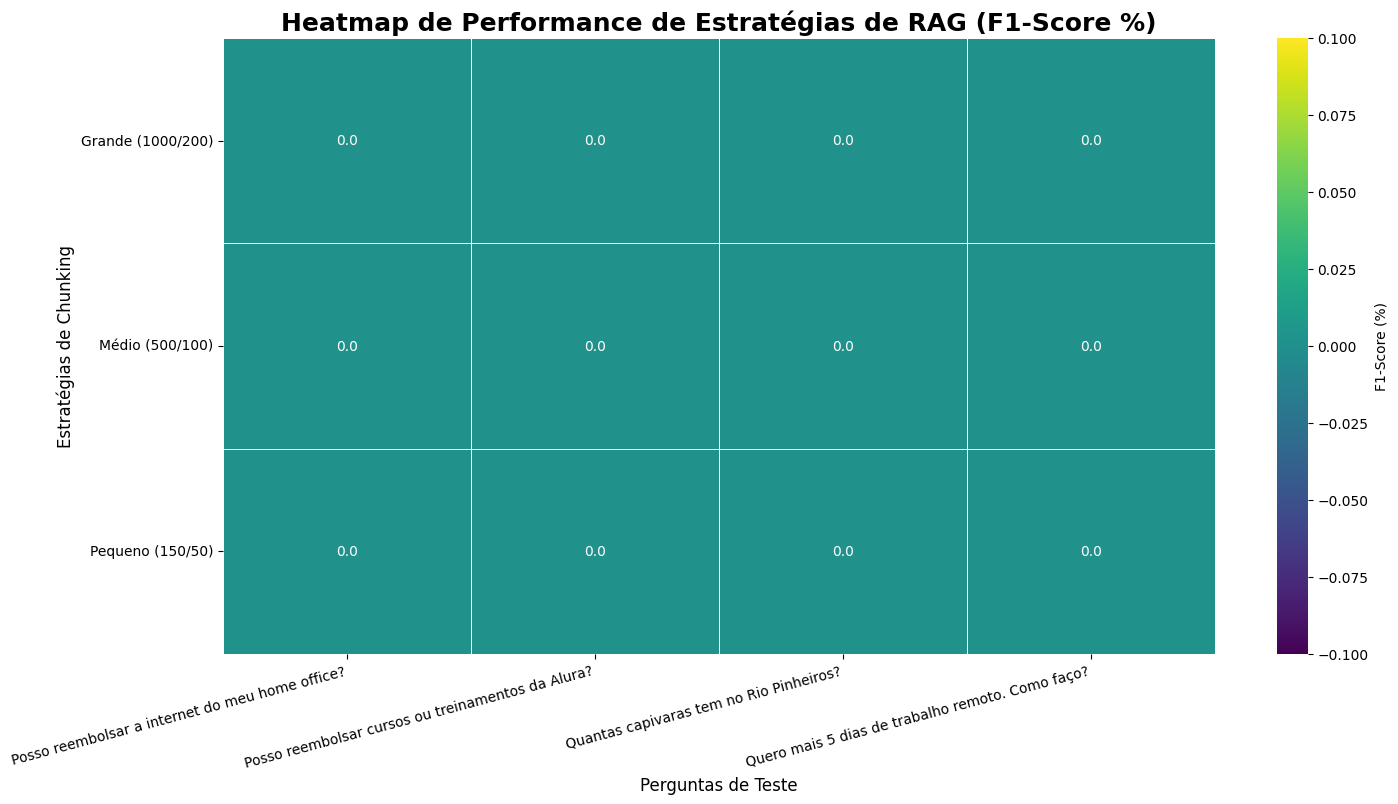


🏆 ANÁLISE FINAL AGREGADA DOS RESULTADOS
📊 TABELA DE PERFORMANCE MÉDIA:
       Estratégia  Avg_F1_Score  Avg_Precision  Avg_Recall
Grande (1000/200)          0.00           0.00        0.00
  Médio (500/100)          0.00           0.00        0.00
 Pequeno (150/50)          0.00           0.00        0.00

🥇 ESTRATÉGIA VENCEDORA (Maior Média de F1-Score): 'Grande (1000/200)'
   - ⚖️ Média de F1-Score: 0.00%
   - 🎯 Média de Precision: 0.00%
   - 🎣 Média de Recall: 0.00%

💡 RECOMENDAÇÃO:
A estratégia vencedora demonstrou o melhor equilíbrio de performance em todo o conjunto de testes.
O heatmap acima mostra visualmente a consistência de cada estratégia. Estratégias com cores consistentemente 'quentes' (amarelo/verde) são as mais robustas.

💾 Resultados da análise comparativa exportados para: rag_analysis_results_20250912_213332.csv


In [17]:
if __name__ == "__main__":
    main()

##Possiveis Melhorias

1- Fallback Api

#### **Nova Célula: Configuração de Modelos com Fallback**

Substituir a célula de "Etapa 1: Configurando Modelos" por esta.

```python
# CÉLULA DE CONFIGURAÇÃO AVANÇADA (com Fallback de API Key)

def setup_models_with_fallback(api_key_names: List[str]) -> Tuple[Optional[ChatGoogleGenerativeAI], Optional[GoogleGenerativeAIEmbeddings]]:
    """
    Tenta inicializar os modelos do Gemini com uma lista de chaves de API em ordem.
    Retorna o primeiro par de modelos que funcionar com sucesso.
    """
    from google.colab import userdata
    
    for key_name in api_key_names:
        print(f"🔄 Tentando inicializar com a chave: '{key_name}'...")
        api_key = userdata.get(key_name)
        
        if not api_key:
            print(f"  - ⚠️ Chave '{key_name}' não encontrada nos segredos. Pulando.")
            continue
            
        try:
            # Tenta inicializar ambos os serviços com a chave atual
            llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0, api_key=api_key)
            embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", api_key=api_key)
            
            # (Opcional) Poderíamos fazer uma pequena chamada de teste aqui para validar a chave,
            # mas por enquanto, a inicialização já é um bom teste.
            
            print(f"  - ✅ Sucesso! Modelos configurados com a chave '{key_name}'.")
            return llm, embeddings
            
        except Exception as e:
            # Captura qualquer erro (rate limit, chave inválida, etc.)
            print(f"  - ❌ Falha com a chave '{key_name}'. Erro: {str(e)[:100]}...") # Mostra preview do erro
            continue # Tenta a próxima chave

    print("\n❌ ERRO FATAL: Nenhuma das chaves de API fornecidas funcionou.")
    return None, None

```

### **Como Usar Isso no seu `main()`**

Agora, a sua célula `main()` fica incrivelmente limpa e legível. Ela apenas define a lista de chaves e chama nossa nova função de setup.

**Na sua célula `main()`:**```python
# Dentro da sua função main()

# --- Etapa 1: Configurando Modelos com Fallback ---
print("\n--- Etapa 1: Configurando Modelos com Fallback ---")

# Defina a ordem de prioridade das suas chaves
api_key_prioridade = ['GEMINI_API_KEY', 'GEMINI_API_KEY_2']

# Chama a nossa nova função robusta
llm, embeddings = setup_models_with_fallback(api_key_prioridade)

if not llm or not embeddings:
    print("Encerrando a análise devido à falha na configuração dos modelos.")
    return

# Cria o adapter para o LLM que funcionou
llm_adapter = LLMAdapter(llm)
```